In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
from tqdm import tqdm

files = os.listdir('UTKFace')

In [4]:
import cv2
images = []
genders = []

for i in tqdm(files):
    split = i.split('_')
    genders.append(np.array(int(split[1])))
    p = 'UTKFace'+'/'+i
    img = cv2.imread(p)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(np.array(img))

100%|███████████████████████████████████████████████████████████████████████████| 23604/23604 [00:26<00:00, 876.12it/s]


1


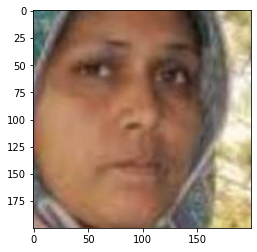

In [7]:
import matplotlib.pyplot as plt
print(genders[15000])
plt.imshow(images[15000])

In [8]:
images = np.array(images)
gender = np.array(genders,np.uint64)

### Split Data

In [9]:
x_train_gender,x_test_gender,y_train_gender,y_test_gender = train_test_split(images,gender,random_state=42)

In [10]:
x_train_gender.shape

(17703, 200, 200, 3)

### Define Gender Model Using Swish

In [11]:
genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='swish', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))

genmodel.add(Conv2D(64, (3,3), activation='swish'))
genmodel.add(MaxPooling2D((2,2)))

genmodel.add(Conv2D(128, (3,3), activation='swish'))
genmodel.add(MaxPooling2D((2,2)))

genmodel.add(Flatten())

genmodel.add(Dense(64, activation='swish'))
genmodel.add(Dropout(0.5))

genmodel.add(Dense(1, activation='sigmoid',name='Gender_OP'))

In [12]:
genmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [13]:
genmodel.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [14]:
datagen = ImageDataGenerator(rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(x_test_gender, y_test_gender,batch_size=64)

In [15]:
history2 = genmodel.fit(train2, epochs=50, shuffle=True, validation_data=test2)

Epoch 1/50
277/277 [==============================] - 495s 2s/step - loss: 0.5779 - accuracy: 0.7055 - val_loss: 0.4402 - val_accuracy: 0.8056
Epoch 2/50
277/277 [==============================] - 490s 2s/step - loss: 0.4807 - accuracy: 0.7750 - val_loss: 0.4212 - val_accuracy: 0.8056
Epoch 3/50
277/277 [==============================] - 482s 2s/step - loss: 0.4543 - accuracy: 0.7895 - val_loss: 0.3849 - val_accuracy: 0.8294
Epoch 4/50
277/277 [==============================] - 478s 2s/step - loss: 0.4283 - accuracy: 0.8056 - val_loss: 0.3615 - val_accuracy: 0.8393
Epoch 5/50
277/277 [==============================] - 481s 2s/step - loss: 0.4198 - accuracy: 0.8069 - val_loss: 0.3517 - val_accuracy: 0.8487
Epoch 6/50
277/277 [==============================] - 478s 2s/step - loss: 0.3858 - accuracy: 0.8245 - val_loss: 0.3269 - val_accuracy: 0.8578
Epoch 7/50
277/277 [==============================] - 481s 2s/step - loss: 0.3669 - accuracy: 0.8377 - val_loss: 0.3084 - val_accuracy: 0.8685

In [16]:
genmodel.save('gendmodel_swish.h5')

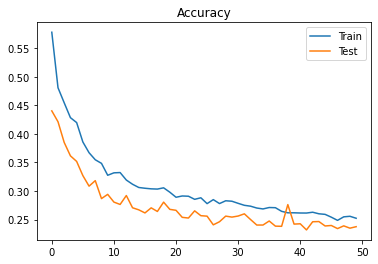

In [19]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Accuracy')
plt.legend(['Train','Test'])
plt.show()

Gender: 0


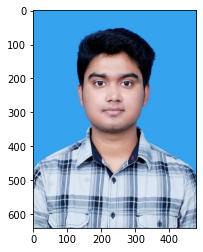

In [32]:
img = cv2.imread('aditya.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = np.array(img)
plt.imshow(img)
img = cv2.resize(img,(200,200))
img = img/255
img = img.reshape(-1, 200, 200, 3)
gender = genmodel.predict(img)
print("Gender:",round(gender[0][0]))

Gender: 1


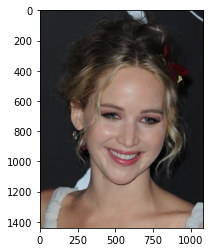

In [33]:
img = cv2.imread('jennifer.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = np.array(img)
plt.imshow(img)
img = cv2.resize(img,(200,200))
img = img/255
img = img.reshape(-1, 200, 200, 3)
gender = genmodel.predict(img)
print("Gender:",round(gender[0][0]))

1

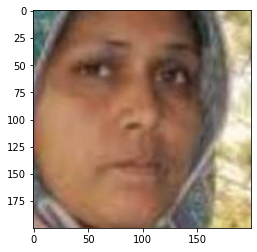

In [35]:
i = images[15000]
plt.imshow(i)
i = i/255
i = i.reshape(-1, 200, 200, 3)
pred = genmodel.predict(i)[0][0]
round(pred)

In [36]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(genmodel, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [38]:
pred=genmodel.predict(x_test_gender)

In [52]:
(round(pred[2][0]))

0

In [53]:
Pred_l=[]
for i in range(len(pred)):
    Pred_l.append((round(pred[i][0])))


In [54]:
from sklearn.metrics import confusion_matrix 

In [59]:
from sklearn.metrics import classification_report 

<AxesSubplot:>

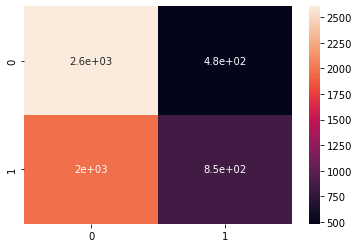

In [57]:
import seaborn as sns

sns.heatmap(results, annot=True)

In [60]:
report=classification_report(y_test_gender, Pred_l)

In [62]:
print(report)

              precision    recall  f1-score   support

           0       0.57      0.84      0.68      3087
           1       0.64      0.30      0.41      2814

    accuracy                           0.59      5901
   macro avg       0.61      0.57      0.55      5901
weighted avg       0.60      0.59      0.55      5901

